# Appendix: Expressivity and Depth

Recall that a ReLU neuron in a fully-connected layer divides its input space into two regions: active and inactive. Then, the output of a layer with $k$ neurons corresponds to a binary $k$-tuple representing the **activation pattern** &mdash; whether each of the $k$ neurons is active or inactive.
All points in a convex region, bounded by the $k$ hyperplanes, share the same activation pattern. Thus, this pattern can be viewed as a signature of the layer's output for that region. Interestingly, activation patterns combine combinatorially across layers, and in the final layer, define a *carving* of the input space. This carving is suggested by the plot below:

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
%config InlineBackend.figure_format = "svg"

RANDOM_SEED = 37
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

In [2]:
from tqdm.notebook import tqdm
from sklearn.datasets import make_moons

x, y = make_moons(1500, noise=0.05, random_state=RANDOM_SEED)
x = torch.tensor(x).float()
y = torch.tensor(y)

model = nn.Sequential(
    nn.Linear(2, 5), nn.ReLU(),
    nn.Linear(5, 5), nn.ReLU(),
    nn.Linear(5, 5), nn.ReLU(),
    nn.Linear(5, 2)
)

optim = torch.optim.Adam(model.parameters(), lr=0.003)

history = []
for step in tqdm(range(1500)):
    s = model(x)
    loss = F.cross_entropy(s, y)
    loss.backward()
    optim.step()
    optim.zero_grad()
    history.append(loss.item())

  0%|          | 0/1500 [00:00<?, ?it/s]

Final loss: 3.71e-04


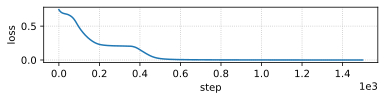

In [3]:
print(f"Final loss: {history[-1]:.2e}")
plt.figure(figsize=(6, 1))
plt.plot(history)
plt.xlabel("step")
plt.grid(linestyle="dotted", alpha=0.8)
plt.ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
plt.ylabel("loss");

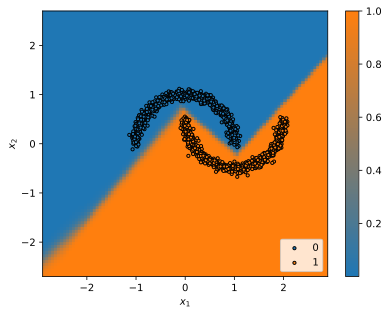

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# Define your custom colormap
colors = ["C0", "C1"]
n_bins = 100
cm = LinearSegmentedColormap.from_list(name="", colors=colors, N=n_bins)

# Create a grid of points
N = 100
LIMIT = 3
u = np.linspace(-LIMIT, LIMIT, N)
v = np.linspace(-LIMIT, LIMIT, N)
X, Y = np.meshgrid(u, v)

# Calculate function values for each point on the grid
Z = np.zeros_like(X)
for i in range(N):
    for j in range(N):
        inp = torch.tensor([[float(X[i, j]), float(Y[i, j])]])
        out = F.softmax(model(inp), dim=1)
        Z[i, j] = out[0][1]

# Create a color plot using the custom colormap
plt.pcolormesh(X, Y, Z, shading='auto', cmap=cm, rasterized=True)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

x0 = x[y == 0]
x1 = x[y == 1]
plt.scatter(x0[:, 0], x0[:, 1], s=10.0, label=0, color="C0", edgecolor="black")
plt.scatter(x1[:, 0], x1[:, 1], s=10.0, label=1, color="C1", edgecolor="black")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.legend(loc="lower right")

plt.xlim(-(LIMIT - 0.3), (LIMIT - 0.3))
plt.ylim(-(LIMIT - 0.3), (LIMIT - 0.3))
plt.show();

Fig. *To model the training data, ReLU neurons collectively carve the input space.*

In this section, our goal is (1) to construct the regions of the input data space $\mathbb{R}^d$ with distinct activation patterns for a fully-connected ReLU network, and (2) count the maximal number of such regions in terms of the width and depth of the network.

## Effect of layer width

Clearly, as we increase the neurons in the layer, we get more convex subsets that partition the input space. The exact upper bound can be calculated as follows (i.e. when the hyperplanes maximally partition the space). Let $r(k, d)$ be the maximal number of regions generated by $k$ hyperplanes in $\mathbb{R}^d.$ It turns out that

$$r(k, d) \leq \sum_{i=0}^d\binom{k}{i}$$

To prove this, we assume that a new hyperplane $H$ can intersect all
hyperplanes existing $k - 1$ hyperplanes. Then, $r(k - 1, d)$ is increased by the number of regions generated within $H$, i.e. $r(k - 1, d- 1).$ Thus,

$$r(k, d) = r(k - 1, d) + r(k - 1, d - 1).$$

This can be seen in {numref}`01-polytopes`. For the base steps, we clearly have $r(1, 2) = 2$ and $r(1, 1) = 2.$ For example, $r(2, 2) = 4$ which makes sense (two hyperplanes maximally divide $\mathbb{R}^2$ into 4 disjoint subsets). Proving the inductive step for $k, d \geq 2$:

$$\begin{aligned}
r(k - 1, d) + r(k - 1, d - 1) 
&\leq \sum_{i=0}^d\binom{k-1}{i} + \sum_{j=0}^{d-1}\binom{k-1}{j} \\ 
&= \binom{k-1}{0} + \sum_{i=0}^{d-1}\binom{k-1}{i + 1} + \sum_{j=0}^{d-1}\binom{k-1}{j} \\
&= \binom{k-1}{0} + \sum_{j=0}^{d-1}\left[\binom{k-1}{j + 1} + \binom{k-1}
{j}\right] \\
&= \binom{k-1}{0} + \sum_{j=0}^{d-1}\binom{k}{j + 1} \quad\quad \text{Pascal's Identity} \\
&= \binom{k}{0} + \sum_{j=1}^{d}\binom{k}{j} \quad\quad\quad\quad \text{i.e.} \binom{k-1}{0} = \binom{k}{0} = 1\\
&= \sum_{j=0}^{d}\binom{k}{j}. \\
\end{aligned}
$$

Recall $\binom{k}{0}$ is 1 (i.e. the empty set). Note that $\binom{k}{d} = \frac{1}{d!}k(k-1)\ldots(k-d+1)$, so that $r(k, d)$ is a polynomial in $k$ of degree $d.$ In other words, $r(k, d) = \Theta(k^d).$ 

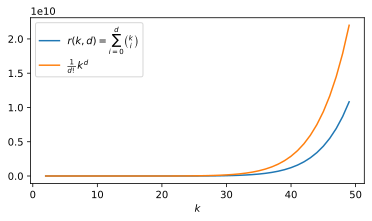

In [5]:
from math import comb, factorial
import matplotlib.pyplot as plt

K = list(range(2, 50))
d = 10
plt.figure(figsize=(6, 3))
plt.plot(K, [sum(comb(k, i) for i in range(0, d + 1)) for k in K], label=r"$r(k, d) = \sum_{i=0}^d\binom{k}{i}$")
plt.plot(K, [(k ** d) / factorial(d) for k in K], label=r"$\frac{1}{d!}k^d$")
plt.xlabel("$k$")
plt.legend();

```{figure} ../../../img/nn/01-polytopes.png
---
name: 01-polytopes
width: 500px
align: center
---
Demonstrating the counting method used by partitioning $\mathbb{R}^2$ with 4 lines.
Here $r(4, 2)$ is computed in two ways as the sum $r(3, 2) + r(3, 1)$ and the sum $\binom{4}{0} + \binom{4}{1} + \binom{4}{2}.$
```

## Effect of network depth

In the previous section, we found that $k$ neurons partition the input space $\mathbb{R}^d$ into $O(k^d)$ convex subsets. In this section, we show that these are further subdivided by neurons in the next layer. This is the benefit of depth: the input space is carved further combinatorially with each layer of the network. 
A deep network with $k_1, \ldots, k_L$ neurons will have an input space carving containing $O({k_1^d} \ldots {k_L^d})$ convex regions. Hence, depth contributes **exponentially** to the expressiveness of the model, while width contributes **polynomially**[^1]:

```{note}
For simplicity, assume that the network has fixed width $k$ and depth $L$, then the input space $\mathbb{R}^d$ is carved into $O(k^{dL})$ regions.
``` 

[^1]: Care must be taken to not bottleneck the network since the partitioning occurs hierarchically. For example, if we use a single ReLU neuron at Layer 1, so that $k = 1$, any further partitioning only occurs along one dimension (determined by the initial layer's weight vector), effectively reducing $\mathbb{R}^d$ to one dimension.
As such, the upper bound $O({k_1^d} \ldots {k_L^d})$ can be optimistic, it assumes maximal intersection of hyperplanes without considering structural constraints that could limit this.

{numref}`relu-polytopes` demonstrates the carving process as the network becomes deep. Recall that the pre-image of disjoint sets under a continuous function are disjoint. 
Hence, we can take the pre-image of the inputs to Layer 2 to further partition the initial partitioning consisting of 4 subsets from Layer 1. For example, `ia` is partitioned into `iaai` and `iaii`, while `aa` is further partitioned to `aaia`, `aaai`, `aaaa`, and `aaii`[^3]. This shows the effect of depth as combinatorially enriching the activation patterns in a network.

Note that all operations are piecewise linear, so that points in the output space (of any layer), that lie on the boundary of a hyperplane in that space, have a pre-image that form a linear surface in the input space $\mathbb{R}^d$. Bend lines occur when the boundary transitions to another activation pattern. For example, let us calculate the part of the *y*-axis that is in the active region of $H_3$ of Layer 2. Let $H_3$ be determined by $(\boldsymbol{\mathsf{w}}_3, {b}_3)$, then that region corresponds to ${\mathsf{w}}_{32} (\boldsymbol{\mathsf{w}}_2 \cdot \boldsymbol{\mathsf{x}} + b_2) + b_3 = 0$ which is a hyperplane parallel to $H_2.$ As $H_3$ transitions to the `aa` region, we get a different activation pattern ${\mathsf{w}}_{32} (\boldsymbol{\mathsf{w}}_2 \cdot \boldsymbol{\mathsf{x}} + b_2) + {\mathsf{w}}_{31} (\boldsymbol{\mathsf{w}}_1 \cdot \boldsymbol{\mathsf{x}} + b_1) + b_3 = 0$ which is still a linear surface in $\mathbb{R}^d.$ Note that this is continuous at the bend point where $\boldsymbol{\mathsf{w}}_1 \cdot \boldsymbol{\mathsf{x}} + b_1 \to 0.$

[^3]: The (interior of) region `aaia` in the input space consist of points that activate both neurons of Layer 1, and activates the second neuron of Layer 2 but not the first.

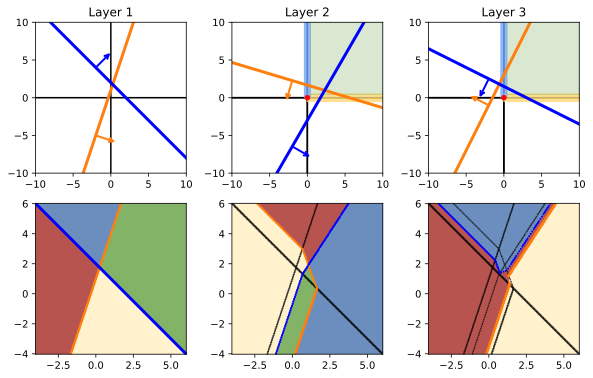

In [6]:
# import itertools
import math
from matplotlib.patches import Circle
from matplotlib.colors import ListedColormap


def plot_example():
    N = 200 # 1000 to generate saved figure
    LIMIT = 5
    SHIFT = 1
    u = np.linspace(-LIMIT + SHIFT, LIMIT + SHIFT, N)
    v = np.linspace(-LIMIT + SHIFT, LIMIT + SHIFT, N)
    X, Y = np.meshgrid(u, v)
    X = X.reshape(-1)
    Y = Y.reshape(-1)

    input_space = torch.stack([torch.tensor(X), torch.tensor(Y)], dim=1).float()
    input_space.shape

    model = nn.Sequential(
        nn.Linear(2, 2), nn.ReLU(),
        nn.Linear(2, 2), nn.ReLU(),
        nn.Linear(2, 2), nn.ReLU(),
    )

    with torch.no_grad():
        model[0].weight[0, 0] = 3.0
        model[0].weight[0, 1] = -1.0
        model[0].bias[0] = 1

        model[0].weight[1, 0] = 1.0
        model[0].weight[1, 1] = 1.0
        model[0].bias[1] = -2

        model[2].weight[0, 0] = -0.90
        model[2].weight[0, 1] = -3.0
        model[2].bias[0] = +5
        
        model[2].weight[1, 0] = 1.73
        model[2].weight[1, 1] = -1.0
        model[2].bias[1] = -3.0

        model[4].weight[0, 0] = -2
        model[4].weight[0, 1] = 1.0
        model[4].bias[0] = -3
        
        model[4].weight[1, 0] = -1.0
        model[4].weight[1, 1] = -2.0
        model[4].bias[1] = 3


    @torch.no_grad()
    def plot_pattern(ax, Z, title="", cmap=None):
        Z = np.array(Z)
        xx = input_space
        x = xx[:, 0].reshape(N, N)
        y = xx[:, 1].reshape(N, N)
        z = Z.reshape(N, N)
        ax.pcolormesh(x, y, z, cmap=cmap, shading="auto", rasterized=True)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=10)


    # y = mx + b & 0 = w1 x + w2 y + b => m = -w1 / w2, b = -b / w2
    with torch.no_grad():
        m00 = -model[0].weight[0, 0] / model[0].weight[0, 1]
        m01 = -model[0].weight[1, 0] / model[0].weight[1, 1]
        b00 = -model[0].bias[0] / model[0].weight[0, 1]
        b01 = -model[0].bias[1] / model[0].weight[1, 1]

        m10 = -model[2].weight[0, 0] / model[2].weight[0, 1]
        m11 = -model[2].weight[1, 0] / model[2].weight[1, 1]
        b10 = -model[2].bias[0] / model[2].weight[0, 1]
        b11 = -model[2].bias[1] / model[2].weight[1, 1]

        m20 = -model[4].weight[0, 0] / model[4].weight[0, 1]
        m21 = -model[4].weight[1, 0] / model[4].weight[1, 1]
        b20 = -model[4].bias[0] / model[4].weight[0, 1]
        b21 = -model[4].bias[1] / model[4].weight[1, 1]

    out0 = F.relu(model[0](input_space))
    out1 = F.relu(model[2](out0))
    out2 = F.relu(model[4](out1))

    # pattern_all = lambda n: list(map(lambda z: "".join(z), itertools.product(["0", "1"], repeat=n)))
    # pattern_map = lambda n: dict([(j, i) for (i, j) in enumerate(random.sample(pattern_all(n), 2 ** n))])
    stringify = lambda Z: list(map(lambda x: "".join([str(j) for j in x]), list(zip(Z[:, 0].tolist(), Z[:, 1].tolist()))))
    p0 = {"00": 0, "11": 1, "01": 2, "10": 3}
    # p1 = pattern_map(4)
    # p2 = pattern_map(6)

    # pattern0 = stringify((out0 > 0).int())
    # pattern1 = list(map(lambda z: "".join(z), zip(pattern0, stringify((out1 > 0).int()))))
    # pattern2 = list(map(lambda z: "".join(z), zip(pattern1, stringify((out2 > 0).int()))))
    # encode0 = list(map(lambda x: p0[x], pattern0))
    # encode1 = list(map(lambda x: p1[x], pattern1))
    # encode2 = list(map(lambda x: p2[x], pattern2))

    pattern0 = stringify((out0 > 0).int())
    pattern1 = stringify((out1 > 0).int())
    pattern2 = stringify((out2 > 0).int())
    final0 = list(map(lambda x: p0[x], pattern0))
    final1 = list(map(lambda x: p0[x], pattern1))
    final2 = list(map(lambda x: p0[x], pattern2))


    ##### Plotting ##### 
    fig, ax = plt.subplots(2, 3, figsize=(10, 6))
    x = np.linspace(-10, 10, 100)
    ax[0, 0].plot(x, m00 * x + b00, color="C1",   linewidth=3)
    ax[0, 0].plot(x, m01 * x + b01, color="blue", linewidth=3)
    ax[0, 1].plot(x, m10 * x + b10, color="C1",   linewidth=3)
    ax[0, 1].plot(x, m11 * x + b11, color="blue", linewidth=3)
    ax[0, 2].plot(x, m20 * x + b20, color="C1",   linewidth=3)
    ax[0, 2].plot(x, m21 * x + b21, color="blue", linewidth=3)

    # arrows
    colors = {0: "C1", 1: "blue"}
    with torch.no_grad():
        for k, j in enumerate([0, 2, 4]):
            for i in [0, 1]:
                m = -model[j].weight[i, 0] / model[j].weight[i, 1]
                b = -model[j].bias[i] / model[j].weight[i, 1]
                w0 = 3 * model[j].weight[i, 0].item() / math.sqrt(model[j].weight[i, 0].item() ** 2 + model[j].weight[i, 1].item() ** 2)
                w1 = 3 * model[j].weight[i, 1].item() / math.sqrt(model[j].weight[i, 0].item() ** 2 + model[j].weight[i, 1].item() ** 2)
                p1 = (-2, m * -2 + b)
                p2 = (-2 + w0, m * -2 + b + w1)
                ax[0, k].annotate(text=None, xy=p2, xytext=p1, arrowprops=dict(arrowstyle='->', color=colors[i], linewidth=2))

    # axes
    for k in range(3):
        ax[0, k].set_aspect("equal")
        ax[0, k].set_xlim(-10, 10)
        ax[0, k].set_ylim(-10, 10)
        ax[0, k].axvline(0, color="k", zorder=0)
        ax[0, k].axhline(0, color="k", zorder=0)

    # regions
    for k in range(1, 3):
        circle = Circle((0, 0), 0.3, color="red", fill=True)
        ax[0, k].set_aspect("equal")
        ax[0, k].set_xlim(-10, 10)
        ax[0, k].set_ylim(-10, 10)
        ax[0, k].axvline(0, color="k", zorder=0)
        ax[0, k].axhline(0, color="k", zorder=0)
        ax[0, k].axhspan(-0.5, 0.5, color="#ffd977", alpha=0.8, xmin=0.5, xmax=1, zorder=1)  # yellow
        ax[0, k].axvspan(-0.4, 0.4, color="#75a7fe", alpha=0.8, ymin=0.5, ymax=1, zorder=1)  # blue
        ax[0, k].axvspan(0.4, 10., color="#82B366", alpha=0.3, ymin=0.52, ymax=1)           # green
        ax[0, k].add_patch(circle)


    # recall p0 = {"00": 0, "11": 1, "01": 2, "10": 3}
    colors = ['#B85450', '#82B366', '#6C8EBF', '#FFF2CC']
    cmap = ListedColormap(colors)

    ax[0, 0].set_title("Layer 1")
    ax[0, 1].set_title("Layer 2")
    ax[0, 2].set_title("Layer 3")
    # plot_pattern(ax[1, 0], encode0)
    # plot_pattern(ax[1, 1], encode1)
    # plot_pattern(ax[1, 2], encode2)
    plot_pattern(ax[1, 0], final0, cmap=cmap)
    plot_pattern(ax[1, 1], final1, cmap=cmap)
    plot_pattern(ax[1, 2], final2, cmap=cmap)

    H1 = input_space[torch.abs(model[0](input_space)[:, 0]) < 1e-1]
    H2 = input_space[torch.abs(model[0](input_space)[:, 1]) < 1e-1]
    ax[1, 0].scatter(H1[:, 0].tolist(), H1[:, 1].tolist(), color="C1", s=1)
    ax[1, 0].scatter(H2[:, 0].tolist(), H2[:, 1].tolist(), color="blue", s=1)

    H3 = input_space[torch.abs(model[2](out0)[:, 0]) < 1e-1]
    H4 = input_space[torch.abs(model[2](out0)[:, 1]) < 1e-1]
    ax[1, 1].scatter(H1[:, 0].tolist(), H1[:, 1].tolist(), color="k", s=0.1)
    ax[1, 1].scatter(H2[:, 0].tolist(), H2[:, 1].tolist(), color="k", s=0.1)
    ax[1, 1].scatter(H3[:, 0].tolist(), H3[:, 1].tolist(), color="C1", s=1)
    ax[1, 1].scatter(H4[:, 0].tolist(), H4[:, 1].tolist(), color="blue", s=1)

    H5 = input_space[torch.abs(model[4](out1)[:, 0]) < 1e-1]
    H6 = input_space[torch.abs(model[4](out1)[:, 1]) < 1e-1]
    ax[1, 2].scatter(H1[:, 0].tolist(), H1[:, 1].tolist(), color="k", s=0.1)
    ax[1, 2].scatter(H2[:, 0].tolist(), H2[:, 1].tolist(), color="k", s=0.1)
    ax[1, 2].scatter(H3[:, 0].tolist(), H3[:, 1].tolist(), color="k", s=0.1)
    ax[1, 2].scatter(H4[:, 0].tolist(), H4[:, 1].tolist(), color="k", s=0.1)
    ax[1, 2].scatter(H5[:, 0].tolist(), H5[:, 1].tolist(), color="C1", s=3)
    ax[1, 2].scatter(H6[:, 0].tolist(), H6[:, 1].tolist(), color="blue", s=1)


plot_example()


```{figure} ../../../img/nn/relu-polytopes.png
---
name: relu-polytopes
width: 800px
align: center
---
Carving the input space with 3 layers each with 2 neurons. (**top**) Activation patterns of ReLU neurons that partition its layer input are obtained from the hyperplanes. This corresponds to a coloring of the input data space (**bottom**). 
Yellow refers to activating the first neuron in the layer (e.g. $H_1$), and blue to the second neuron (e.g. $H_2$). Green for both, and red for none. This coloring determine the part of the output space (next upper right plot) where they are mapped onto by the current layer. See discussion for further analysis.
```

The new coloring is reflected based on the activation pattern in that layer. Finally, in Layer 3, we see the final activation pattern for each input region. Note that the inputs to a layer $\ell$ is given by $f^{\ell-1} \circ \ldots \circ f^0 (\boldsymbol{\mathsf{X}})$ where $f^0(\boldsymbol{\mathsf{X}}) = \boldsymbol{\mathsf{X}}.$ This sequence is shown on the top part of the figure, while the bottom figures show the evolution of the input space partitioning. The partitioning in the final layer reflects allows us (in theory) to read off the model predictions. Consequently, a more complex model tends to exhibit more partitions in its carving graph, representing its ability to capture finer distinctions in the input space.

Another thing to note is that general topological features are preserved in the pre-image of each partioning of the output space in terms of activation patterns. For example, the region `(a, i)` of Layer 2 (colored yellow), corresponds to the colored region of Layer 1 (bottom left), but with the point $(0, 0)$ expanded to an entire region, surrounded by some of the blue and yellow regions.
A similar reasoning applies in coloring the adjacent region `(a, a)` of the same layer.
Looking at the last layer, $H_6$ first passes through the `ai` region of the previous layer, then to some of `aa`, and finally to `ia`. Meanwhile, its positive region covers all of `ii`. On the other hand, $H_5$ only passes through `aa` and `ia`. This corresponds to the small strip `aaiaia`. The small subset of `ia` that is in `(i, i)` (i.e. negative region of both $H_5$ and $H_6$) can be seen as the small strip `aaiaii` in the input carving of Layer 3. Note that as $H_5$ and $H_6$ intersect in the *y*-axis, this strip vanishes. Interestingly, we can see from these examples that the relative volume of regions separated in the output are generally preserved in the input carving.

<br>

**Example.** Plotting activation patterns for the above trained model:

In [7]:
N = 500
LIMIT = 3
u = np.linspace(-LIMIT, LIMIT, N)
v = np.linspace(-LIMIT, LIMIT, N)
X, Y = np.meshgrid(u, v)
X = X.reshape(-1)
Y = Y.reshape(-1)

input_space = torch.stack([torch.tensor(X), torch.tensor(Y)], dim=1).float()
input_space.shape

torch.Size([250000, 2])

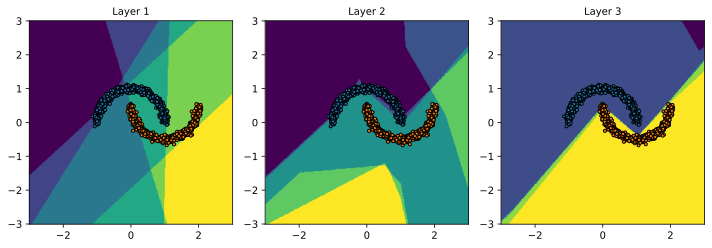

In [8]:
@torch.no_grad()
def plot_pattern(ax, out, weights=(1, 1, 1, 1, 1,), title=""):
    w = torch.tensor(weights).reshape(1, -1)
    Z = (w * (out > 0).int()).sum(dim=1).detach().cpu().numpy()   # simplify: 2^5 -> 5
    xx = input_space
    x0 = x[y == 0]
    x1 = x[y == 1]
    ax.scatter(x0[:, 0], x0[:, 1], s=10.0, label=0, color="C0", edgecolor="black", zorder=2)
    ax.scatter(x1[:, 0], x1[:, 1], s=10.0, label=1, color="C1", edgecolor="black", zorder=2)
    ax.pcolormesh(xx[:, 0].reshape(N, N), xx[:, 1].reshape(N, N), Z.reshape(N, N), shading="auto", rasterized=True)
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=10)


fig, ax = plt.subplots(1, 3, figsize=(10, 4))
out0 = F.relu(model[0](input_space))
out1 = F.relu(model[2](out0))
out2 = F.relu(model[4](out1))
plot_pattern(ax[0], out0, title="Layer 1")
plot_pattern(ax[1], out1, title="Layer 2")
plot_pattern(ax[2], out2, weights=model[6].weight[1], title="Layer 3")
fig.tight_layout()

To simplify, instead of coloring activation patterns, we count total activations per region. Note that regions for final layer are colored based on activations (set to 0 or 1) weighted for class 1.